In [ ]:
SEED = 1234

import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
!pip install brian2
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00


In [ ]:
def sum_product_NOT(p0):
  return 1 - p0

In [ ]:
ww = 0.33

In [ ]:
T_time = 5000
t_interval = 10
N_size = int(T_time/t_interval)

# Generate random inputs
inp0_index = np.random.randint(0, 2, N_size)
inp1_index = np.ones(N_size)

# Logical NOT operation
NOT_result = 1 - inp0_index
Negative_NOT_result = inp0_index

# Create the time arrays
inp_time = array(range(5, T_time+1, t_interval))*ms
train_p_time = array(range(6, T_time+2, t_interval))*ms
train_n_time = array(range(4, T_time+1, t_interval))*ms


In [ ]:
# The times that spikes accure
spike_time_0 = inp_time[inp0_index == 1];
spike_time_1 = inp_time[inp1_index == 1];
spike_time_p = train_p_time[NOT_result == 1];
spike_time_n = train_n_time[NOT_result == 0];

In [ ]:
start_scope()

V_th = -0.50
V_rest = -0.80
wmax = 1
wmin = -1
base_lr = 0.02
Apre = 0.25
decay_rate = - 0.00065
Apost = - Apre * 0.6
tau_s = 10*ms # tau for the STDP

eqs = '''
dv/dt = (V_rest - v)/tau : 1
tau : second
t_since_start = (t/ms) : 1  # Track time in ms
'''

#Inputs
inp0 = SpikeGeneratorGroup(1, zeros(len(spike_time_0)), spike_time_0)
inp1 = SpikeGeneratorGroup(1, zeros(len(spike_time_1)), spike_time_1)

# Training Inputs
inpT = SpikeGeneratorGroup(1, zeros(len(spike_time_p)), spike_time_p)
inpT_n = SpikeGeneratorGroup(1, zeros(len(spike_time_n)), spike_time_n)


# Patern layer
P = NeuronGroup(2, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
#output layer
O = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')

P.tau = 5*ms
O.tau = 5*ms

# Inputs:

feedforward0 = Synapses(inp0, P, on_pre='v += ww')
feedforward0.connect(i=0, j = 0)

feedforward3 = Synapses(inp1, P, on_pre='v += ww')
feedforward3.connect(i=0, j = 1)

#Train spikes:

feedforwardT0 = Synapses(inpT, O, on_pre='v += ww')
feedforwardT0.connect(i = 0, j= 0)

feedforwardT0_n = Synapses(inpT_n, O, on_pre='v += ww')
feedforwardT0_n.connect(i = 0, j= 0)

#Trainable synapses with diferent weights
S_NOT = Synapses(P, O,
             '''
             w : 1
             lr = base_lr * exp(decay_rate * t_since_start) : 1
             dapre/dt = -apre/tau_s : 1 (clock-driven)
             dapost/dt = -apost/tau_s : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre * lr
             w = clip(w+apost, wmin, wmax)
             ''',
             on_post='''
             apost += Apost * lr
             w = clip(w+apre, wmin, wmax)
             ''', method='linear')
S_NOT.connect()
M_NOT = StateMonitor(S_NOT, ['w', 'apre', 'apost'], record=True)

MP = StateMonitor(P, ['v'], record=True)
MO = StateMonitor(O, ['v'], record=True)

run(T_time*ms)

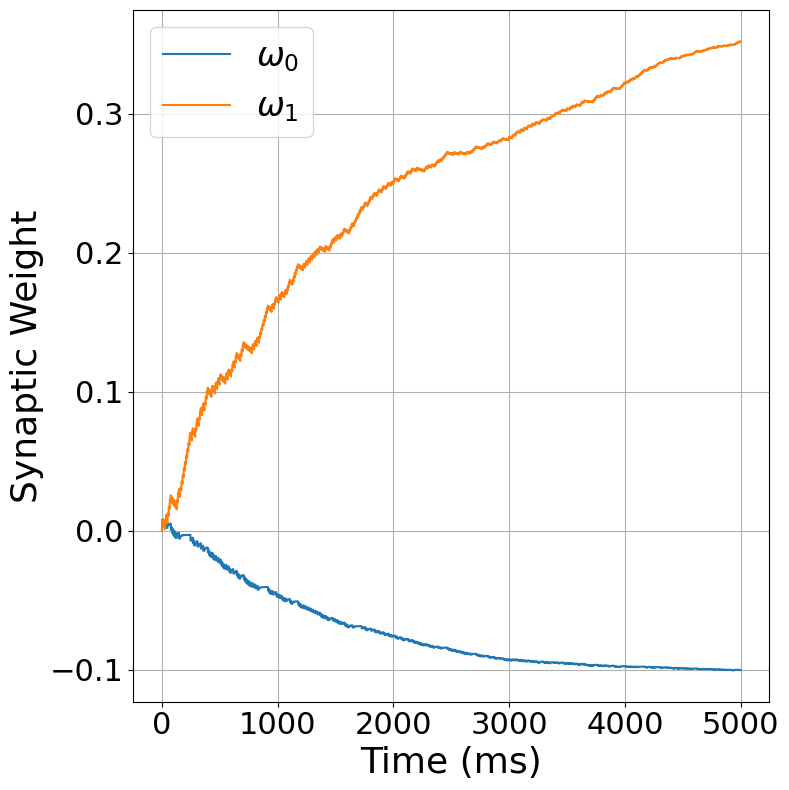

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(M_NOT.t/ms, M_NOT.w[0], label='$\omega_0$')
plt.plot(M_NOT.t/ms, M_NOT.w[1], label='$\omega_1$')

plt.legend(fontsize=24)  # Legend font size
plt.xlabel('Time (ms)', fontsize=26)
plt.ylabel('Synaptic Weight', fontsize=26)
plt.xticks(fontsize=22)  # Tick label sizes
plt.yticks(fontsize=22)
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig("synaptic_weights_NOT.png")
plt.savefig("synaptic_weights_NOT.svg")
plt.show()


In [ ]:
def test_network(p0, p1, T, t_interval, S_weights):
    start_scope()

    V_th = -0.50
    V_rest = -0.80

    eqs = '''
    dv/dt = (V_rest - v)/tau : 1
    tau : second
    '''

    # Inputs

    v0 = array(np.random.binomial(size=int(T/t_interval)+1, n=1, p= p0))
    spike_time0 = v0*linspace(0, T, int(T/t_interval)+1)
    times0 = array(spike_time0[spike_time0 != 0])*ms
    indices0 = array(zeros(len(times0)))

    inp0 = SpikeGeneratorGroup(1,indices0, times0)

    v1 = array(np.random.binomial(size=int(T/t_interval)+1, n=1, p= p1))
    spike_time = v1*linspace(0, T, int(T/t_interval)+1)
    times1 = array(spike_time[spike_time != 0])*ms
    indices1 = array(zeros(len(times1)))

    inp1 = SpikeGeneratorGroup(1,indices1, times1)

    # Pattern layer
    P = NeuronGroup(2, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
    P.tau = 5*ms

    # Output layer
    O = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
    O.tau = 5*ms

    # Input to pattern connections
    feedforward0 = Synapses(inp0, P, on_pre='v += ww')
    feedforward0.connect(i=0, j=0)

    feedforward1 = Synapses(inp1, P, on_pre='v += ww')
    feedforward1.connect(i=0, j=1)

    # Trainable synapses from pattern to output
    S_test = Synapses(P, O, '''w : 1''', on_pre='v += w')
    S_test.connect()
    S_test.w = S_weights

    # Monitors
    MP = StateMonitor(P, ['v'], record=True)
    MO = StateMonitor(O, ['v'], record=True)
    SO = SpikeMonitor(O)

    # Run the simulation
    run(T * ms)

    return  (len(SO.t)-1)/int(T/t_interval)


In [ ]:
# Input test cases
test_input = [(.3, .4), (.2, .6), (.8, .5), (.7, .3),
              (.9, .7), (.6, .4), (.5, .1), (.3, .7)]

In [ ]:
snn_output_NOT = []
sp_output_NOT = []
T_test = 10000
for i in test_input:
  p0, p1 = i
  snn_output_NOT.append(test_network(p0, 1, T_test, t_interval, S_NOT.w))
  sp_output_NOT.append(sum_product_NOT(p0))

In [ ]:
test_input = np.array(test_input)
snn_output_NOT = np.array(snn_output_NOT)
sp_output_NOT = np.array(sp_output_NOT)

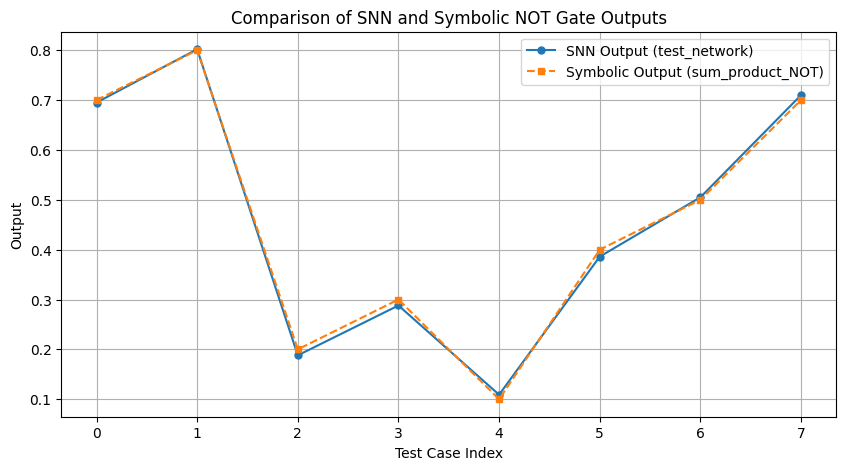

In [ ]:
# Create figure and axes
plt.figure(figsize=(10, 5))

# Plot SNN outputs
plt.plot(snn_output_NOT, 'o-', label='SNN Output (test_network)', markersize=5)

# Plot symbolic processing outputs
plt.plot(sp_output_NOT, 's--', label='Symbolic Output (sum_product_NOT)', markersize=5)

# Add labels and title
plt.xlabel('Test Case Index')
plt.ylabel('Output')
plt.title('Comparison of SNN and Symbolic NOT Gate Outputs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [ ]:
np.savez('NOT_data.npz',
         snn=snn_output_NOT,
         sp=sp_output_NOT,
         t=M_NOT.t / ms,
         w0=M_NOT.w[0],
         w1=M_NOT.w[1])